## Polynomial Regression

Data may not always follow a linear relationship from the independent variable $X$ to the dependent variable $Y$. Trying to fit a linear model on non-linear data would result in low accuracy and high loss.

The polynomial model can be represented mathematically as:

$$
y_i = \theta_0 + \theta_1 x_i + \theta_2 x_i^2 + \cdots + \theta_d x_i^d
$$

Now, the prediction, $\hat{y}$, is computed as

$$ \hat y =  X \theta =
\begin{bmatrix}
    1 & x_{1}       & x_{1}^2 & \cdots & x_{1}^d \\
    1 & x_{2}       & x_{2}^2 & \cdots & x_{2}^d \\
    \vdots & \vdots       & \vdots & \ddots & \vdots \\
    1 & x_{n}       & x_{n}^2 & \cdots & x_{n}^d
\end{bmatrix}
\begin{bmatrix}\theta_0 \\ \theta_1 \\ \vdots \\ \theta_{d} 
\end{bmatrix}=
\begin{bmatrix}
    \theta_0 + \theta_1 x_{1} + \theta_2 x_{1}^2 + \cdots + \theta_{d}  x_{1}^d \\
    \theta_0 + \theta_1 x_{2} + \theta_2 x_{2}^2 + \cdots + \theta_{d}  x_{2}^d  \\
    \vdots   \\
    \theta_0 + \theta_1 x_{n} + \theta_2 x_{n}^2 + \cdots + \theta_{d}  x_{n}^d
\end{bmatrix} 
= \begin{bmatrix}\hat y_1 \\ \hat y_2 \\ \vdots \\ \hat y_{n} 
\end{bmatrix}$$


### Generate random polynomial data

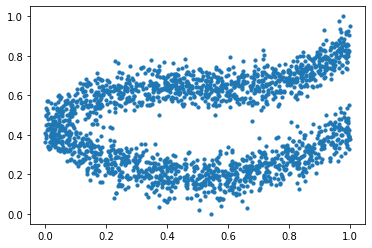

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_data(data):
  return (data - np.min(data))/(np.max(data) - np.min(data))

np.random.seed(33)
x = np.random.uniform(-10, 10, 1000)
poly_coeffs = np.random.uniform(-1,1, size=(4,1))
y = poly_coeffs[0] + poly_coeffs[1]*x + poly_coeffs[2]*(x ** 2) + poly_coeffs[3]*(x ** 3) + np.random.normal(0, 250, 1000)

x2 = np.random.uniform(-10, 10, 1000)
poly_coeffs = np.random.uniform(-1,1, size=(3,1))
y2 = poly_coeffs[0] - 2000 + poly_coeffs[1]*x2 + 50*poly_coeffs[2]*(x2 ** 2)  + np.random.normal(0, 250, 1000)

x = np.concatenate([x,x2])
y = np.concatenate([y,y2])
x = normalize_data(x)
y = normalize_data(y)

plt.scatter(x,y, s=10)
plt.show()

poly_data = np.hstack((x.reshape(-1,1),y.reshape(-1,1)))
np.random.shuffle(poly_data)
x = poly_data[:,0]
y = poly_data[:,1]

The diagram above shows the general shape of the data, which clearly cannot be separated linearally.

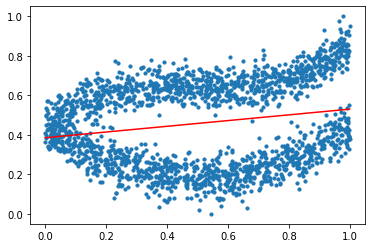

In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x.reshape(-1,1), y)

def compute_line_from_regr(X_data, y_data, regr):
    l_bound = np.min(X_data)
    r_bound = np.max(X_data)
    return [l_bound, r_bound], [l_bound * regr.coef_ + regr.intercept_, r_bound * regr.coef_ + regr.intercept_]

plt.scatter(x,y, s=10)
line_x, line_y = compute_line_from_regr(x.reshape(-1,1),y,reg)
plt.plot(line_x, line_y, color='r')
plt.show()

### Weight Regularization

The above diagram shows that this data does not properly follow a linear relationship. In the following sections, a polynomial model will be made to fit the data more appropriately.

When using polynomial regression, it is possible to overfit. This happens when the model has a higher dimension than the data.

There are two ways to mitigate this problem of overfitting and avoid learning polynomials that are too complex for the data:

1.   Choose an order $d$ that closely matches the data.
2.   Modify the loss to keep weights small to flatten the polynomial by regularizing the weights.

For this problem, we will regularize the weights. So the loss function now becomes:

$$
J(\theta)=\frac{1}{2n}\sum^{n}_{i=1}(h^{(i)}-y^{(i)})^2 + \lambda \sum^{d}_{j=1} \theta^2_j
$$

where, the first term is the original loss function and the second term is the regularizing term with a new hyperparameter $\lambda$ to control the amount of regularizing on the weights. The validation loss will be used to adjust $\lambda$.

The gradient descent algorithm used in each learning step also changes to:

$$
\frac{\partial}{\partial\theta_j}J(\theta) = \frac{1}{n} \sum_{i=1}^{n} ( h^{(i)}-y^{(i)})x_{i,j}  + 2 \lambda\theta_j 
$$

We apply this gradient the same way as before in our gradient descent algorithm:
$$
 \theta_j = \theta_j - \alpha \frac{\partial}{\partial\theta_j}J(\theta)
$$



In [8]:
# Takes raw data in and splits the data into 
# train, test, and val sets for X and y
# Returns X_train, y_train, X_test, y_test, X_val, y_val
def train_test_validation_split(data, test_size=.20, validation_size=.20):
  X_no_bias = data[:, :-1]
  Y = data[:, -1]

  #bias trick for X
  x_0 = np.ones((len(X_no_bias), 1), dtype=int)
  X = np.hstack((x_0, X_no_bias))

  #splitting X's
  test = int(len(data)*test_size)
  train = int(len(data)* (1 - (test_size + validation_size)))
  val_raw_index = int(len(data) * validation_size)
  val = val_raw_index + train

  X_train = X[:train]
  y_train = Y[:train]

  X_val = X[train:val]
  y_val = Y[train:val]

  X_test = X[val:]
  y_test = Y[val:]
  
  return X_train, y_train, X_test, y_test, X_val, y_val

X_train, y_train, X_test, y_test, X_val, y_val = train_test_validation_split(poly_data)
print("X train shape: ", X_train.shape)
print("X test shape: ", X_test.shape)
print("Y train shape: ", y_train.shape)
print("y test shape: ", y_test.shape)
print("X val shape: ", X_val.shape)
print("y val shape: ", y_val.shape)

# Adds columns to your data up to the specified degree.
# Ex: If degree=3, (x) -> (x, x^2, x^3)
def add_polycols(X,degree):
  x_col = X[:,-1]

  for i in range(2, degree+1):
    X = np.hstack((X,(x_col**i).reshape(-1,1)))
  return X


# Takes the target values and predicted values and calculates 
# the absolute error between them 
def mse(y_pred, y_true):
  return (1/(2*(len(y_pred))) * np.sum((y_pred - y_true)**2))


# Derivative of MSE. Returns a vector of derivations of loss 
# with respect to each of the dimensions
def mse_derivative(X,y,theta):
  h = np.dot(X, theta)
  return ((1/len(X)) * np.dot((h - y), X))

# Computes L2 norm from theta scaled by lambda.
# Returns a scalar L2 norm.
def l2norm(theta, lamb):
  theta_sum = np.sum(theta[1:]**2)
  return lamb * theta_sum

# Computes derivative of L2 norm scaled by lambda.
# Returns a vector of derivative of L2 norms.
def l2norm_derivative(theta, lamb):
  theta_no_bias_reg = 2 * lamb * theta[1:]
  return np.hstack((0, theta_no_bias_reg))


# Computes total cost (cost function + regularization term)
def compute_cost(X, y, theta, lamb):
  h = np.dot(X, theta)
  return mse(h, y) + l2norm(theta, lamb)

# Gradient descent step. 
# Takes X, y, theta vector, and alpha. 
# Returns an updated theta vector.
def gradient_descent_step(X, y, theta, alpha, lamb):
  gradient = mse_derivative(X, y, theta) + l2norm_derivative(theta, lamb)
  theta = theta - (alpha * gradient)
  return theta

def polynomial_regression(data, degree, num_epochs=100000, alpha=1e-4, lamb=0):
  # Get training, testing, and validation sets by calling train_test_validation_split()
  X_train, y_train, X_test, y_test, X_val, y_val = train_test_validation_split(data)

  # Record training and validation errors in lists
  train_errors = []
  val_errors = []

  # Add the appropriate amount of columns to each sets of data.
  X_train = add_polycols(X_train, degree)
  X_val = add_polycols(X_val, degree)
  X_test = add_polycols(X_test, degree)

  # Define theta
  theta = np.zeros((X_train.shape[1]))

  # Carry out training loop
  for i in range(num_epochs):
    train_error = compute_cost(X_train, y_train, theta, lamb)
    train_errors.append(train_error)

    val_error = compute_cost(X_val, y_val, theta, lamb)
    val_errors.append(val_error)
    
    # Do gradient descent on the training set
    theta = gradient_descent_step(X_train, y_train, theta, alpha, lamb)

    # This prints the validation loss
    if i % (num_epochs//10) == 0:
      print(f'({i} epochs) Training loss: {train_error}, Validation loss: {val_error}') 
  print(f'({i} epochs) Final training loss: {train_error}, Final validation loss: {val_error}') 
  
  # Compute the testing loss
  test_error = compute_cost(X_test, y_test, theta, lamb)
  print(f'Final testing loss: {test_error}')
  return theta, train_errors, val_errors

X train shape:  (1200, 2)
X test shape:  (400, 2)
Y train shape:  (1200,)
y test shape:  (400,)
X val shape:  (400, 2)
y val shape:  (400,)


### Training


In [9]:
# degree d
polynomial_order = 10

# regularization constant lambda
regularization_param = 0.005

theta, train_errors, val_errors = polynomial_regression(poly_data, polynomial_order, lamb=regularization_param, num_epochs=100000, alpha=1e-4)

(0 epochs) Training loss: 0.13126079748777478, Validation loss: 0.12391363483637967
(10000 epochs) Training loss: 0.028700601800394212, Validation loss: 0.027678808004741283
(20000 epochs) Training loss: 0.02399987574555639, Validation loss: 0.02416168259659806
(30000 epochs) Training loss: 0.022868831279541618, Validation loss: 0.023080053506823038
(40000 epochs) Training loss: 0.02234125367222559, Validation loss: 0.022464379555689355
(50000 epochs) Training loss: 0.02207163749762936, Validation loss: 0.02211071692252232
(60000 epochs) Training loss: 0.02192434449638485, Validation loss: 0.021895691659019736
(70000 epochs) Training loss: 0.021836288933359854, Validation loss: 0.021752767299403838
(80000 epochs) Training loss: 0.021777745596578614, Validation loss: 0.02164849137639214
(90000 epochs) Training loss: 0.02173462149770068, Validation loss: 0.021566189223801848
(99999 epochs) Final training loss: 0.021700166697389323, Final validation loss: 0.021497405645312332
Final testin

### Results

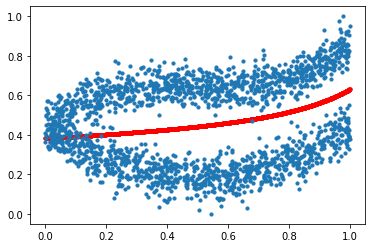

In [10]:
# Call plot_results() to see how your polynomial fits.
def plot_results(theta, X, Y):
    y_hat = sum([t*X**i for i,t in enumerate(theta)])
    plt.scatter(X, y_hat, s=10, color='r')
    plt.scatter(X, Y, s=10)
    plt.show()

plot_results(theta, x, y)

### Discussion and Evaluation

As shown in the diagram above, the polynomial model fit the data much better than a linear regression model. After 10,000 iterations, the testing loss was minimized to 0.0217.